# Modeling Notebook - Positive/Negative Classifier

In [217]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import string
import re
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 

import pandas as pd
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

np.random.seed(42)


In [243]:
#  Function Definitions 
lemmatizer = WordNetLemmatizer()

def get_eng_stopwords_list():
    # Get English stopwords, punctuation, and 'empty text' signifiers (like empty quotes and ...)
    return stopwords.words('english')  + list(string.punctuation) + ["''", '""', '...', '``']

def get_social_media_stopwords_list():
    return stopwords.words('english') + ['rt', 'link','&', 'SXSW', 'sxsw', 'austin'] + list(string.punctuation) + ["''", '""', '..', '...', '``']


def clean_tweet(tweet):
    # remove hashtags - only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # remove hyperlinks
    # to remove links that start with HTTP/HTTPS in the tweet
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', tweet, flags=re.MULTILINE)
     # to remove other url links
    tweet = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', tweet, flags=re.MULTILINE) 
    
    # lemmatize
    lem_word = lemmatizer.lemmatize(tweet)
    return tweet


def tokenize_tweet(tweet):
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tweet_tokenizer.tokenize(tweet)
    #TODO: any stemming you might want to do
    return tokens


def process_tweet_text_encode_to_ascii(tweet, stopwords_list):
    #tokenize, lowercase each token, remove stopwords
    stopwords_removed = ''
    tweet = clean_tweet(tweet)
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    try:
        tweet_encode = tweet.encode("ascii", "ignore")
        tweet_decode = tweet_encode.decode()
        tokens = tweet_tokenizer.tokenize(tweet_decode)
        stopwords_removed = [token for token in tokens if token not in stopwords_list]
    except:
        print('Could not encode/decode ', tweet )
    return stopwords_removed

def plot_word_cloud(text, word_max, stopwords_list, bg_color='black'):
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            max_words=word_max)
    cloud.generate(text)
    
    # plot it
    plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()


#TODO: figure out why this is not working to apply the image as mask
def plot_word_cloud_with_mask(text, word_max, stopwords_list, bg_color='black'):
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    twitter_mask = np.array(Image.open('../images/twitter.png'))
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            mask=twitter_mask,
                            contour_width=3, 
                            contour_color='steelblue',
                            max_words=word_max)
    cloud.generate(text)

    # store to file
    cloud.to_file(path.join(d, "twitter_cloud.png"))

    # plot it
    #plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.imshow(twitter_mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()


def plot_pretty_cf(predictor, xtest, ytest, cmap='Blues', normalize='true', title=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(predictor, xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()



In [244]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding = 'unicode_escape')
print(pos_tweets.shape)

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding = 'unicode_escape')
print(neg_tweets.shape)

neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding = 'unicode_escape')
print(neutral_tweets.shape)

all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')
print(all_tweets.shape)

(2861, 7)
(544, 7)
(5293, 7)
(8698, 7)


In [245]:

for t in all_tweets[:9]['tweet_text']:
    print(t)
    print(process_tweet_text_encode_to_ascii(t, get_social_media_stopwords_list()))

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['3g', 'iphone', '3', 'hrs', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'stations']
@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
['know', 'awesome', 'ipad', 'iphone', 'app', 'likely', 'appreciate', 'design', 'also', "they're", 'giving', 'free', 'ts']
@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
['wait', 'ipad', '2', 'also', 'sale']
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
['hope', "year's", 'festival', 'crashy', "year's", 'iphone', 'app']
@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
['great', 'stuff', 'fri', 'marissa', 'mayer', 'google', 'tim', "o'reilly", 'tech', 'books', 'conferences

## Corpus Exploration
* What are the most common words found in Positive, Negative and Neutral Tweets?

In [246]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets

positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        neutral_tweet_words.append(word)


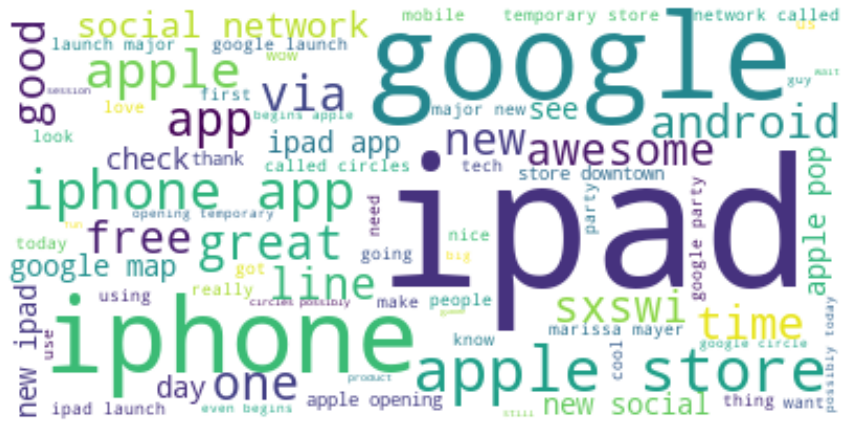

In [247]:
# Postive Tweets top 50 words
positive_text = ' '.join(word for word in positive_tweet_words)
plot_word_cloud(positive_text, 75, get_social_media_stopwords_list(), 'white')

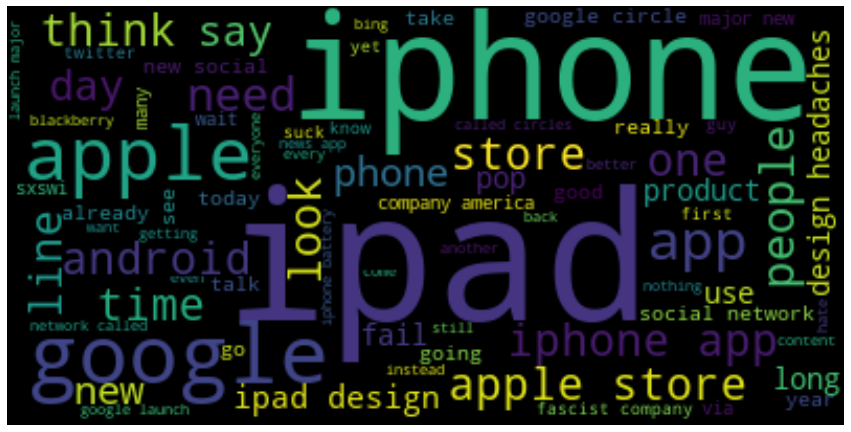

In [248]:
# Negative Tweets top 50 words
negative_text = ' '.join(word for word in negative_tweet_words)
plot_word_cloud(negative_text, 75, get_social_media_stopwords_list())

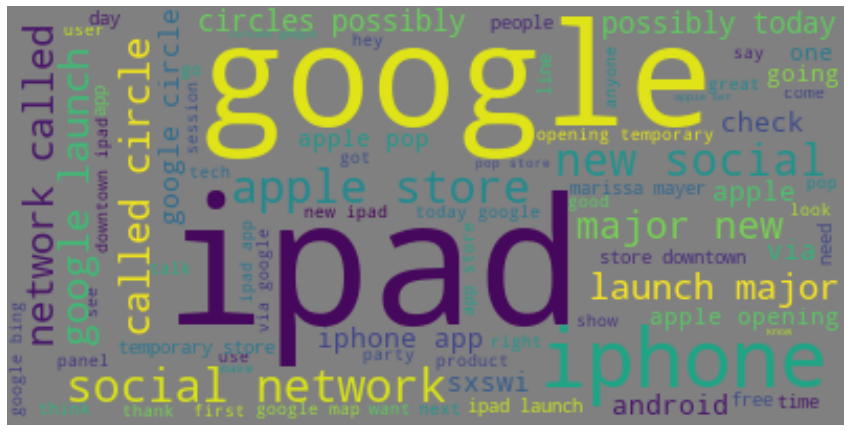

In [249]:
# Neutral Tweets top 50 words
neutral_text = ' '.join(word for word in neutral_tweet_words)
plot_word_cloud(neutral_text, 75, get_social_media_stopwords_list(), 'grey')

## Text Processing 

In [250]:
# clean the tweets before performing TD-IDF vetgorization
#all_tweets['tweet_text'] = all_tweets.apply(lambda row: clean_tweet(row['tweet_text']), axis=1)
all_tweets['tweet_text'] = all_tweets['tweet_text'].apply(clean_tweet)
display(all_tweets['tweet_text'].head(3))


0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for iPad 2 also. They...
Name: tweet_text, dtype: object

## Processing Done..let's get ready to build some Classification Models

In [251]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist?
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# The data is imbalanced, use the weighted F1 score to analyze our models' performance

In [252]:
corpus_binary = all_tweets[all_tweets['sentiment'] != 'Neutral']['tweet_text'].tolist()
labels_binary = all_tweets[all_tweets['sentiment'] != 'Neutral']['sentiment'].tolist()

train_tweets_binary, test_tweets_binary, train_sentiment_binary, test_sentiment_binary = train_test_split(corpus_binary, labels_binary, test_size=0.3, random_state=42)

In [253]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.


from sklearn.feature_extraction.text import TfidfVectorizer

# Use tokenzer for tweets and the customized stopwords list
vectorizer_for_binary = TfidfVectorizer(tokenizer=tokenize_tweet, 
                                        stop_words=get_social_media_stopwords_list(), 
                                        strip_accents='ascii',
                                        decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train_binary = vectorizer_for_binary.fit_transform(train_tweets_binary)
# Creat a vectorized version of the TEST data
tf_idf_data_test_binary = vectorizer_for_binary.transform(test_tweets_binary)

In [254]:
# TF-IDF - Let's check out the vocab for the ENTIRE corpus of Pos and Neg Tweets...Train and Test
print(len(vectorizer_for_binary.vocabulary_.keys()))

4933


In [255]:
# Let's see what terms were important
# print idf values 
df_idf = pd.DataFrame(vectorizer_for_binary.idf_, index=vectorizer_for_binary.get_feature_names(),columns=["idf_weights"]) 
 
df_idf.sort_values(by=['idf_weights'], ascending=False)[:50]

,idf_weights
zoom,8.083388
halls,8.083388
ringing,8.083388
rimmed,8.083388
rim,8.083388
gratification,8.083388
rightfully,8.083388
right-brain,8.083388
greatest,8.083388
greeted,8.083388


In [256]:
# Model creation
# create some models and fit them to our vectorized training data
nb_classifier_binary = MultinomialNB()
rf_classifier_binary = RandomForestClassifier(n_estimators=100)

In [257]:
nb_classifier_binary.fit(tf_idf_data_train_binary, train_sentiment_binary)
nb_train_preds_binary = nb_classifier_binary.predict(tf_idf_data_train_binary)
nb_test_preds_binary = nb_classifier_binary.predict(tf_idf_data_test_binary)

In [258]:
nb_binary_train_score = accuracy_score(train_sentiment_binary, nb_train_preds_binary)
nb_binary_test_score = accuracy_score(test_sentiment_binary, nb_test_preds_binary)
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_binary_train_score, nb_binary_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8565 		 Testing Accuracy: 0.8679


In [259]:
print(classification_report(test_sentiment_binary, nb_test_preds_binary, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       1.00      0.06      0.11       143
    Positive       0.87      1.00      0.93       879

    accuracy                           0.87      1022
   macro avg       0.93      0.53      0.52      1022
weighted avg       0.89      0.87      0.81      1022



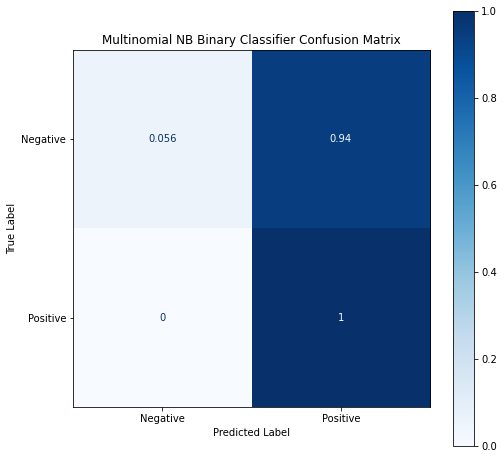

In [260]:
plot_pretty_cf(nb_classifier_binary, tf_idf_data_test_binary, test_sentiment_binary, title='Multinomial NB Binary Classifier Confusion Matrix')

In [261]:
rf_classifier_binary.fit(tf_idf_data_train_binary, train_sentiment_binary)
rf_train_preds_binary = rf_classifier_binary.predict(tf_idf_data_train_binary)
rf_test_preds_binary = rf_classifier_binary.predict(tf_idf_data_test_binary)

In [262]:
rf_binary_train_score = accuracy_score(train_sentiment_binary, rf_train_preds_binary)
rf_binary_test_score = accuracy_score(test_sentiment_binary, rf_test_preds_binary)
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_binary_train_score, rf_binary_test_score))

Random Forest
Training Accuracy: 0.9983 		 Testing Accuracy: 0.8904


In [263]:
print(classification_report(test_sentiment_binary, rf_test_preds_binary, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.88      0.25      0.39       143
    Positive       0.89      0.99      0.94       879

    accuracy                           0.89      1022
   macro avg       0.88      0.62      0.67      1022
weighted avg       0.89      0.89      0.86      1022



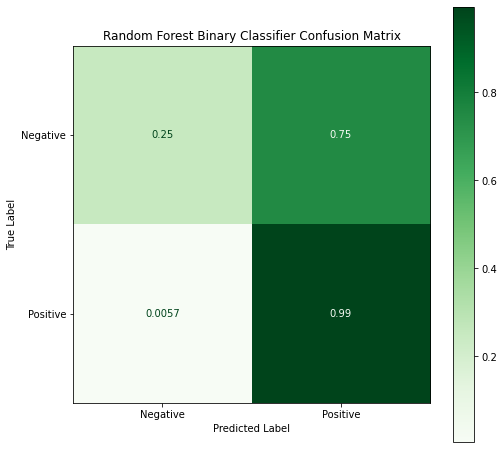

In [264]:
plot_pretty_cf(rf_classifier_binary, tf_idf_data_test_binary, test_sentiment_binary, cmap='Greens', title='Random Forest Binary Classifier Confusion Matrix')

### Random Forest was better than NB...but still pretty crummy due to a high number of False Negatives: incorrectly classifed a Negative sentiment tweet as a Positive sentitment tween. Also, there is MASSIVE overfitting.

## Try some other types of models

In [265]:
svc_clf_binary = Pipeline([('tfidf_vec', TfidfVectorizer(tokenizer=tokenize_tweet, strip_accents='unicode',decode_error='ignore')), 
                    ('clf', LinearSVC())])

In [266]:
svc_clf_binary.fit(train_tweets_binary, train_sentiment_binary)

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(decode_error='ignore', strip_accents='unicode',
                                 tokenizer=<function tokenize_tweet at 0x7f1ac402e6a8>)),
                ('clf', LinearSVC())])

In [267]:
svc_binary_train_predictions = svc_clf_binary.predict(train_tweets_binary)
svc_binary_test_predictions = svc_clf_binary.predict(test_tweets_binary)

In [268]:
svc_train_score_binary = accuracy_score(train_sentiment_binary, svc_binary_train_predictions)
svc_test_score_binary = accuracy_score(test_sentiment_binary, svc_binary_test_predictions)
print("SVC")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(svc_train_score_binary, svc_test_score_binary))

SVC
Training Accuracy: 0.992 		 Testing Accuracy: 0.9012


In [269]:
print(classification_report(test_sentiment_binary, svc_binary_test_predictions, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.76      0.43      0.55       143
    Positive       0.91      0.98      0.94       879

    accuracy                           0.90      1022
   macro avg       0.83      0.71      0.75      1022
weighted avg       0.89      0.90      0.89      1022



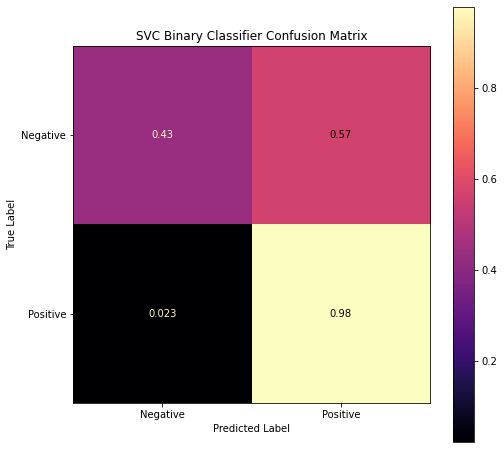

In [270]:
plot_pretty_cf(svc_clf_binary, test_tweets_binary, test_sentiment_binary, cmap='magma', title='SVC Binary Classifier Confusion Matrix')